# Inspecting DeepConsensus examples and running model

## Imports



Run these in order. These libraries are finicky about which order they're installed and loaded in.

In [1]:
import tensorflow as tf

In [5]:
! pip install -qq deepconsensus[cpu]==0.3.1

     |████████████████████████████████| 145 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 55.3 MB/s 
     |████████████████████████████████| 2.1 MB 56.7 MB/s 
     |████████████████████████████████| 15.0 MB 48.0 MB/s 
     |████████████████████████████████| 77 kB 5.9 MB/s 
     |████████████████████████████████| 438 kB 66.7 MB/s 
     |████████████████████████████████| 232.6 MB 63 kB/s 
     |████████████████████████████████| 5.8 MB 37.0 MB/s 
     |████████████████████████████████| 48.3 MB 1.4 MB/s 
     |████████████████████████████████| 1.2 MB 68.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 92 kB 11.4 MB/s 
     |████████████████████████████████| 352 kB 60.9 MB/s 
     |████████████████████████████████| 237 kB 88.2 MB/s 
     |████████████████████████████████| 4.6 MB 49.4 MB/s 
     |████████████████████████████████| 1.1 MB 85.6 MB/s 
     |████████████████████████████████| 636 kB 67.3 MB/s 
     |█████████████

In [6]:
# This will say "ERROR: Failed building wheel for google-nucleus", but that is fine, Nucleus will still work.
! pip install google-nucleus==0.5.9  # for visualization only
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import colorama
import numpy as np
import random
from deepconsensus.models import model_configs
from deepconsensus.models import model_utils
from deepconsensus.models import data_providers
from deepconsensus.utils import dc_constants
from nucleus.util import vis

## Define some useful visualization utilities

In [8]:
def show_rows_for_one_example(rows, max_passes=20):
  """Break out the black/white matrix into subreads, ccs, PW, IP, etc.

  For each of `max_subreads`, we have four pieces of information: bases, PW, IP,
  and strand. We also have one row for CCS, and four rows for SN (in that
  order).
  The information is structured as follows:
  Bases: rows 0 to  (params.max_passes - 1)
  PW: rows (params.max_passes) to (params.max_passes * 2 - 1)
  IP: rows (params.max_passes * 2) to (params.max_passes * 3 - 1)
  Strand: rows (params.max_passes * 3) to (params.max_passes * 4 - 1)
  CCS+SN: rows (params.max_passes * 4) to (params.max_passes * 4 + 5)
  """
  print('bases:')
  vis.array_to_png(rows[0:max_passes])
  print('PW: pulse-width')
  pw = rows[max_passes:max_passes*2]
  vis.array_to_png(pw)
  print('IP: inter-pulse duration')
  ip = rows[max_passes*2:max_passes*3]
  vis.array_to_png(ip)

  print('Strand:')
  vis.array_to_png(rows[max_passes*3:-5])

  print('CCS:')
  ccs = rows[-5:-4]
  vis.array_to_png(ccs)
  print('SN:')
  sn = rows[-4:]
  vis.array_to_png(sn)

In [9]:
def encoded_sequence_to_string(encoded_sequence):
  """Convert an encoded sequence (a series of integers) to a DNA string."""
  return ''.join([dc_constants.VOCAB[int(base)] for base in encoded_sequence])


def get_ccs_matrix(rows_for_one_example):
  """Slice the encoded CCS out of the 2d rows matrix of one example."""
  return rows_for_one_example[-5, :]


def get_ccs_seq(rows_for_one_example):
  """Get CCS string out of the 2d rows matrix of one example."""
  return encoded_sequence_to_string(get_ccs_matrix(rows_for_one_example))


def colorful(seq):
  """Add colors to a sequence of DNA."""
  fore = colorama.Fore
  background = colorama.Back
  colors = {
      'A': fore.GREEN,
      'C': fore.BLUE,
      'G': fore.YELLOW,
      'T': fore.RED,
      dc_constants.GAP_OR_PAD: background.WHITE
  }
  reset = fore.BLACK + background.RESET
  colored_seq = [f'{colors.get(base, reset)}{base}{reset}' for base in seq]
  return ''.join(colored_seq)


def show_example(batch, example_i, ypreds=None, max_passes=20):
  """Show an example with subreads, ccs, predictions, and labels."""
  batch_size = batch['rows'].shape[0]
  rows = batch['rows'][example_i, :, :, 0]
  ccs_i = get_ccs_seq(rows)
  print(f'Example: {example_i} of {batch_size} (batch)')
  print('How the sequences are represented for the model:')
  subreads = rows[0:max_passes, :]
  for subread_i in range(len(subreads)):
    print(f'Subread {subread_i + 1}\t',
          colorful(encoded_sequence_to_string(subreads[subread_i, :])))
  print('ccs:\t\t', colorful(ccs_i))
  if ypreds is not None:
    predicted_sequence = encoded_sequence_to_string(ypreds[example_i])
    print('prediction:\t', colorful(predicted_sequence))
  if 'label' in batch:
    label = encoded_sequence_to_string(batch['label'][example_i])
    print('label:\t\t', colorful(label))
  print('\n')


## Load the model

In [28]:
! mkdir deepconsensus_model
! gsutil cp -r gs://brain-genomics-public/research/deepconsensus/models/v0.3/model_checkpoint/* deepconsensus_model/

Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/model_checkpoint/checkpoint.data-00000-of-00001...
Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/model_checkpoint/checkpoint.index...
Copying gs://brain-genomics-public/research/deepconsensus/models/v0.3/model_checkpoint/params.json...
\ [3 files][102.4 MiB/102.4 MiB]                                                
Operation completed over 3 objects/102.4 MiB.                                    


In [12]:
! gsutil cp gs://brain-genomics-public/research/deepconsensus/test_data/v0.3/tf-test-00001-of-00500.tfrecord.gz ./tf-test.tfrecord.gz

Copying gs://brain-genomics-public/research/deepconsensus/test_data/v0.3/tf-test-00001-of-00500.tfrecord.gz...
- [1 files][122.4 MiB/122.4 MiB]                                                
Operation completed over 1 objects/122.4 MiB.                                    


In [31]:
checkpoint_path = 'deepconsensus_model/checkpoint'
params = model_utils.read_params_from_json(checkpoint_path=checkpoint_path)

model = model_utils.get_model(params)
checkpoint = tf.train.Checkpoint(model=model)

row_size = data_providers.get_total_rows(params.max_passes)
input_shape = (1, row_size, params.max_length, params.num_channels)
model_utils.print_model_summary(model, input_shape)
checkpoint.restore(
    checkpoint_path).expect_partial().assert_existing_objects_matched()

model_utils.modify_params(
  params=params,
  speedy=True,
  max_length=120,
  is_training=False)

Model: "encoder_only_learned_values_transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 relative_position_embedding  multiple                 0         
 _4 (RelativePositionEmbeddi                                     
 ng)                                                             
                                                                 
 encoder_stack_4 (EncoderSta  multiple                 8784128   
 ck)                                                             
                                                                 
 dense_8 (Dense)             multiple                  1405      
                                                                 
 softmax_4 (Softmax)         multiple                  0         
                                                                 
 bases_embedding (ModifiedOn  multiple                 40        
 DeviceEmbedding)        

# Load examples from tfrecords

In [17]:
tfrecord_path = 'tf-test.tfrecord.gz'

# Number of examples:
batch_size = 20  #@param

ds = data_providers.get_dataset(tfrecord_path,
                                num_epochs=None,
                                batch_size=batch_size,
                                params=params,
                                inference=False)

# Just get one batch to inspect:
for batch in ds.take(1):
  break

keys = ['name', 'label', 'rows', 'num_passes', 'window_pos']
for key in keys:
  print(f'{key}.shape: {batch[key].shape}')

name.shape: (20, 1)
label.shape: (20, 120)
rows.shape: (20, 85, 120, 1)
num_passes.shape: (20, 1)
window_pos.shape: (20, 1)


## Visualize the rows of one example. This is what the model sees.

Rows is of shape `[batch_size, input_size, length, 1]`.

So when we take `rows[example_i,:,:,0]`, that is one example in the batch, and we get a 2D matrix (getting rid of the last dimension that was only a placeholder for model code).

Example: 16 of 20 (batch)
ZMW: b'm64062_190803_042216/393833/ccs'
window_pos: 13551 bp (where example starts within the CCS read)
num_passes: 6 subreads
What the model sees:


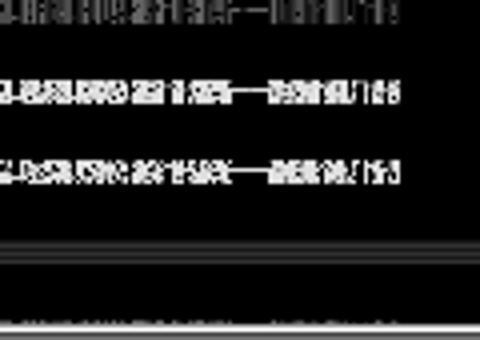

In [18]:
example_i = int(random.random() * batch_size)

print(f'Example: {example_i} of {batch_size} (batch)')
print('ZMW:', batch['name'][example_i].numpy()[0])
print('window_pos:', int(batch['window_pos'][example_i].numpy()), 'bp (where example starts within the CCS read)')
print('num_passes:', int(batch['num_passes'][example_i]), 'subreads')
print('What the model sees:')
vis.array_to_png(batch['rows'][example_i,:,:,0])

### Let's break that down

Each matrix is composed of multiple data types layered in rows. The bases, pulse-width, inter-pulse duration, and strand are per-subread, up to the max number of subreads (this is in params.max_passes, which as of DeepConsensus v0.3 is 20). The input also contains a draft circular consensus sequence (CCS) from PacBio and the signal-to-noise ratio (SN).

Example: 16 of 20 (batch)
bases:


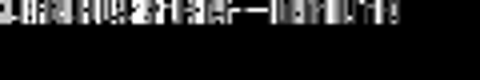

PW: pulse-width


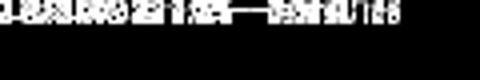

IP: inter-pulse duration


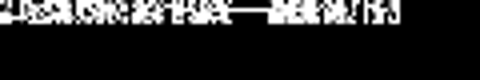

Strand:


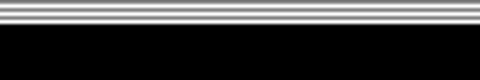

CCS:


SN:


In [19]:
print(f'Example: {example_i} of {batch_size} (batch)')
show_rows_for_one_example(rows=batch['rows'][example_i,:,:,0])

# Run the model

Run the model on `rows`, which is the input data for the model that we visualized above.

In [22]:
softmax_output = model.predict(batch['rows'])
print(softmax_output.shape)

(20, 120, 5)


In [23]:
y_preds = np.argmax(softmax_output, -1)
print(y_preds.shape)

(20, 120)


### Interpreting y_preds output

In [24]:
prediction = y_preds[example_i]
print(f'Prediction for example {example_i}:')
print(prediction)
print('Which translates to:')
print(encoded_sequence_to_string(prediction))

Prediction for example 16:
[3 3 3 0 0 2 4 2 4 1 4 2 1 2 2 2 3 3 0 1 2 4 1 2 4 1 3 1 4 1 3 1 0 4 4 4 3
 2 1 4 4 0 0 4 2 1 0 3 2 4 4 1 2 2 3 3 1 3 0 0 0 0 0 0 0 0 0 1 4 1 2 1 1 2
 3 3 1 1 2 1 0 2 4 3 2 1 2 0 1 0 0 1 0 1 4 2 0 1 3 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]
Which translates to:
CCC  TGTGAGTATTTCC ATGATGACAGACA GGGCTAGG  GTA CTGGATTCCAC         AGATAATCCAATA TGCTAT A  A AGT ACA                    


In [25]:
print('For reference, the alphabet is:')
print('\n'.join([f'{i} -> "{s}"' for i,s in enumerate(dc_constants.VOCAB)]))

For reference, the alphabet is:
0 -> " "
1 -> "A"
2 -> "T"
3 -> "C"
4 -> "G"


# Visualize example sequences alongside prediction and label

In [26]:
show_example(batch, example_i, ypreds=y_preds)

Example: 16 of 20 (batch)
How the sequences are represented for the model:
Subread 1	 CCC  TGTGA TATTTCC ATGATGACAGACA GGGCTAGG  GTA CTGGAATCCAC         AGAT ATCCATTA TGCTAT AAGA AGT AAA                    
Subread 2	  CC  TGAGAGTA TTCC ATGATGACAG CA GTGCTAAGCTGTA ATGGATTCCA          AGATAATCCAATATTGCTAT A  ATTGT ACA                    
Subread 3	  CC  TGTGA TATTTCC AT ATGACAGTCA  GGC AAG  GTATCT GATTCCACGGATGGGGGAGATAATCCAATT TGCTAT A  A AGTAACA                    
Subread 4	 CCC  TGTGAGTATTGCC ATGATGACAGA A GGGCTAGG  GTA  TGGAT  AAC         AGATAAT CAATA TGCTAT A  A AGT ACA                    
Subread 5	 CCCGTTG GAGTATTTCCAATGATGACA ACATGGGATAGG  GTA CTGGATTCCAC         AGATAATCCAATA TGCTATGA  A AGT A A                    
Subread 6	 CCC  TGTGAGTA TTCC ATGA GA AGACA GGGCTAGG  TTA CTGGATT CAC         AGAAAATCCAATA TGCTATAA  A AGT ACA                    
Subread 7	                                                                                                                         
S